In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Iniciando o PySpark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3c69e71daaec59aeabb2a6588c8b0b27b60c43dcc37e9c0a797561ed4914d82e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .master('local[*]') \
  .appName("3° e 4 Semana") \
  .getOrCreate()
spark

# Leitura dos Dados

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/ChallengeDataScience2°Ed/data/treated_dataset_parquet"
data = spark.read.parquet(DATA_PATH)

# Análise de Correlação

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
correlation_dataframe = data.drop("id").toPandas().corr()

<Axes: >

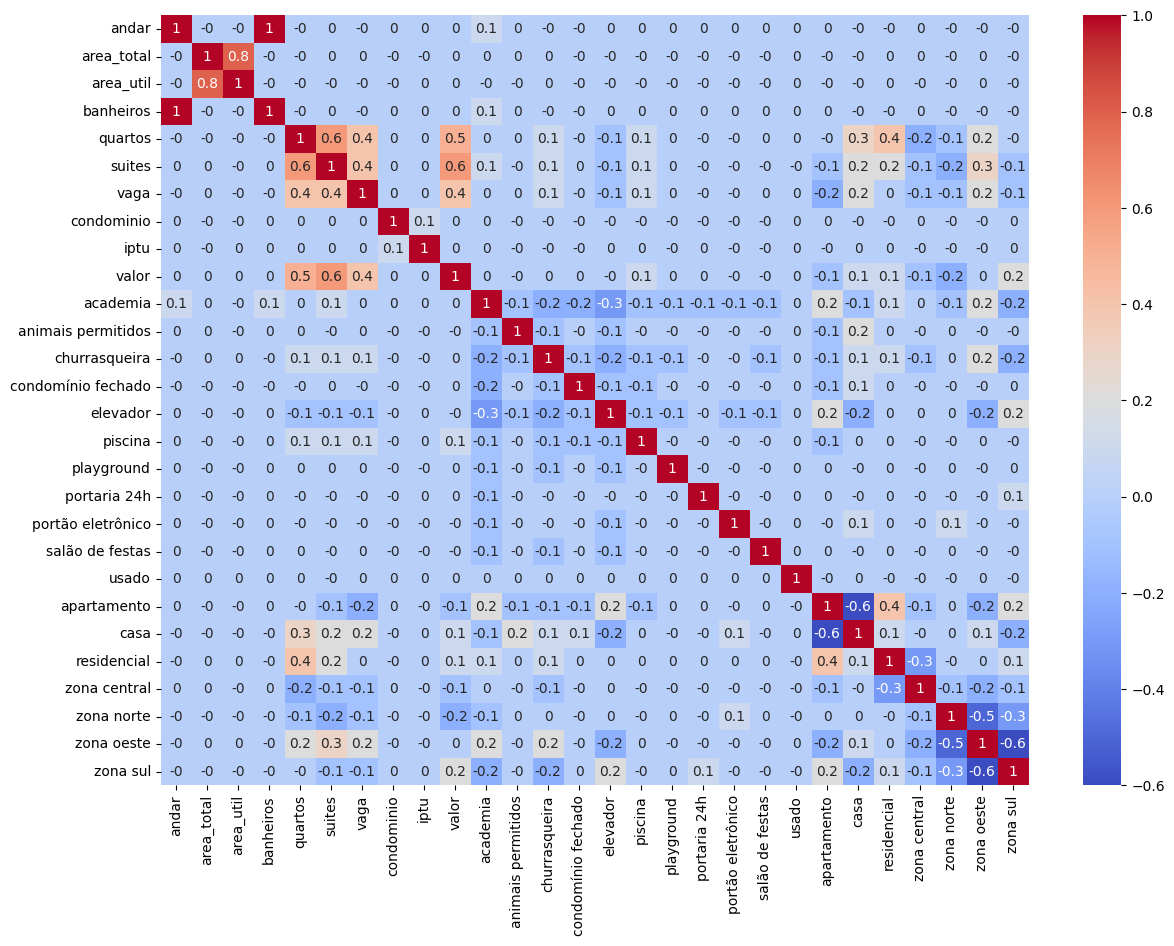

In [ ]:
plt.figure(figsize=(14,10))
paleta = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(correlation_dataframe.round(1), annot=True, cmap=paleta)

# Preparação dos Dados

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline

## Vetorização

In [ ]:
features = data.columns
features.remove("id")
features.remove("area_total")
features

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'academia',
 'animais permitidos',
 'churrasqueira',
 'condomínio fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria 24h',
 'portão eletrônico',
 'salão de festas',
 'usado',
 'apartamento',
 'casa',
 'residencial',
 'zona central',
 'zona norte',
 'zona oeste',
 'zona sul']

In [ ]:
vec_assembler = VectorAssembler(inputCols=features, outputCol="features")
transformed_data = vec_assembler.transform(data)

In [ ]:
transformed_data.select("features").show(n=5, truncate=False)

+--------------------------------------------------------------------------------------------------------------+
|features                                                                                                      |
+--------------------------------------------------------------------------------------------------------------+
|(27,[0,1,2,3,6,7,8,9,19,20,22,23],[2.0,35.0,2.0,1.0,100.0,100.0,245000.0,1.0,1.0,1.0,1.0,1.0])                |
|(27,[0,1,2,3,4,5,6,7,8,13,19,20,22,25],[5.0,169.0,5.0,4.0,2.0,2.0,998.0,2600.0,955000.0,1.0,1.0,1.0,1.0,1.0]) |
|(27,[0,1,2,3,4,5,6,7,8,14,19,21,22,25],[1.0,360.0,1.0,4.0,4.0,3.0,800.0,1300.0,3790000.0,1.0,1.0,1.0,1.0,1.0])|
|(27,[0,1,2,3,4,5,6,7,8,9,19,20,22,25],[1.0,82.0,1.0,2.0,1.0,1.0,736.0,998.0,280000.0,1.0,1.0,1.0,1.0,1.0])    |
|(27,[1,3,4,5,6,7,8,9,19,20,22,25],[50.0,2.0,1.0,1.0,504.0,50.0,249900.0,1.0,1.0,1.0,1.0,1.0])                 |
+-----------------------------------------------------------------------------------------------

## Feature Scaling (Standardization)

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(transformed_data)
transformed_data = scaler_model.transform(transformed_data)

In [ ]:
transformed_data.select("features", "scaled_features").show(n=5, truncate=False)

+--------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                      |scaled_features                                                                                                                                                                                                                                                                                                          |
+--------------------------------------------------------------------------------------------------------------+----------------------------------

## Redução de Dimensionalidade (PCA)

In [ ]:
pca = PCA(k=27, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(transformed_data)

In [ ]:
variance_list = [sum(pca_model.explainedVariance[0:i+1]) for i in range(len(pca_model.explainedVariance))]

In [ ]:
k = 0
for i in variance_list:
  if i <= 0.9:
    k+=1
k

18

In [ ]:
pca = PCA(k=k, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(transformed_data)
transformed_data = pca_model.transform(transformed_data)

In [ ]:
transformed_data.select("features", "scaled_features", "pca_features").show(n=5, truncate=True)

+--------------------+--------------------+--------------------+
|            features|     scaled_features|        pca_features|
+--------------------+--------------------+--------------------+
|(27,[0,1,2,3,6,7,...|(27,[0,1,2,3,6,7,...|[-0.0553984332044...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-3.2346919390529...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-6.9373947468144...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-2.4818061445850...|
|(27,[1,3,4,5,6,7,...|(27,[1,3,4,5,6,7,...|[-2.4799484686208...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
print(f"Explained Variance: {sum(pca_model.explainedVariance)*100:.2f}%")

Explained Variance: 87.50%


## Pipeline

In [ ]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=features, outputCol="features"),
    StandardScaler(inputCol="features", outputCol="scaled_features"),
    PCA(k=k, inputCol="scaled_features", outputCol="pca_features")
  ]
)

In [ ]:
pipeline_model = pipeline.fit(data)
transformed_data = pipeline_model.transform(data)

In [ ]:
transformed_data.select("features", "scaled_features", "pca_features").show(n=10)

+--------------------+--------------------+--------------------+
|            features|     scaled_features|        pca_features|
+--------------------+--------------------+--------------------+
|(27,[0,1,2,3,6,7,...|(27,[0,1,2,3,6,7,...|[-0.0553984332044...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-3.2346919390529...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-6.9373947468144...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-2.4818061445850...|
|(27,[1,3,4,5,6,7,...|(27,[1,3,4,5,6,7,...|[-2.4799484686208...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-2.6773449090555...|
|(27,[0,1,2,3,4,5,...|(27,[0,1,2,3,4,5,...|[-1.9785362769842...|
|(27,[1,3,4,5,7,8,...|(27,[1,3,4,5,7,8,...|[-4.6282706350211...|
|(27,[0,1,2,3,5,6,...|(27,[0,1,2,3,5,6,...|[-1.2625219849711...|
|(27,[1,3,4,5,6,7,...|(27,[1,3,4,5,6,7,...|[-4.1669119265113...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



# Clustering

In [ ]:
SEED = 112358

## Elbow Method

In [ ]:
from sklearn.cluster import KMeans as skKMeans
from math import sqrt

In [ ]:
features = transformed_data.select("pca_features").collect()

In [ ]:
X = np.array([row['pca_features'] for row in features])

In [ ]:
wcss = []
for i in range(3, 31):
  model = skKMeans(n_clusters=i, random_state=SEED)
  model.fit(X)
  wcss.append(model.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

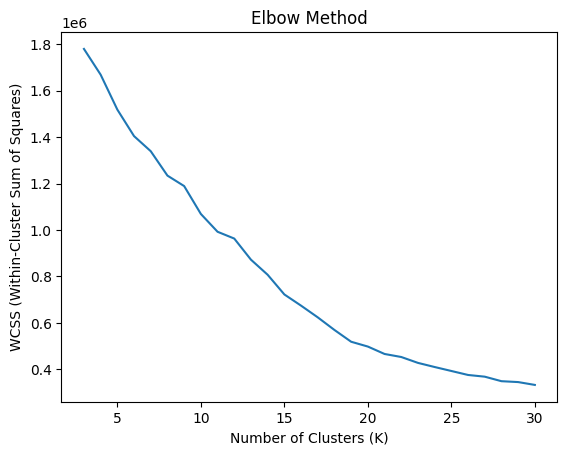

In [ ]:
plt.plot(range(3, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

**Fórmula**: Cálculo da distância entre uma reta e um ponto

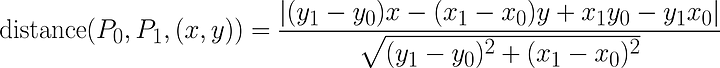

In [ ]:
def best_number_of_clusters(wcss):
  x0, y0 = 3, wcss[0]
  x1, y1 = 30, wcss[len(wcss)-1]

  distances = []

  for i in range(0, len(wcss)):
    x = i+3
    y = wcss[i]
    numerator = abs(((y1 - y0) * x) - ((x1 - x0) * y) + x1*y0 - y1*x0)
    denominator = sqrt(pow((y1 - y0), 2) + pow((x1 - x0), 2))
    distances.append(numerator/denominator)
  return distances

In [ ]:
distances = best_number_of_clusters(wcss)
k = distances.index(max(distances))
print(f"Número ideal de clusters: {k}")

Número ideal de clusters: 12


## Treino do Modelo (K-Means)

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans(
  k=k,
  featuresCol="pca_features",
  predictionCol="cluster",
  seed=SEED
)

model_kmeans = kmeans.fit(transformed_data)
transformed_data = model_kmeans.transform(transformed_data)

In [ ]:
transformed_data.select("id", "pca_features", "cluster").show(5)

+--------------------+--------------------+-------+
|                  id|        pca_features|cluster|
+--------------------+--------------------+-------+
|00002dd9-cc74-480...|[-0.0553984332044...|      3|
|00003eb1-1d77-43f...|[-3.2346919390529...|     10|
|0001ab8a-60a2-4bb...|[-6.9373947468144...|      9|
|0004b470-5332-446...|[-2.4818061445850...|      0|
|0004ff84-199d-402...|[-2.4799484686208...|      0|
+--------------------+--------------------+-------+
only showing top 5 rows



In [ ]:
# Retorna um dataframe contendo todos os registros de um Cluster especificado
def print_cluster(n=-1):
  if n == -1:
    n = int(input("Digite o número do cluster (0 a 11): "))
  try:
    if n not in range(0, 12):
      raise Exception
    return transformed_data.filter(transformed_data.cluster == n).select("id", "pca_features", "cluster")
  except:
    print("Número inválido!")
    return

# Análise dos Resultados

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import FloatType
from scipy.spatial.distance import euclidean

In [ ]:
print_cluster(0).show(5, False)

+------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|id                                  |pca_features                                                                                                                                                                                                                                                                                                                                                        |cluster|
+------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
def calculate_distance(base_propertie_features , other_properties_features):
  return euclidean(base_propertie_features, other_properties_features)

udf_calculate_distance = f.udf(calculate_distance, FloatType())

In [ ]:
# Retorna um dataframe com a distância euclidiana do imóvel com ID específicado e outros imóveis do mesmo Cluster ordenado de forma crescente
def similar_properties(id=''):
  if id == '':
    id = str(input("ID do imóvel: "))
  row = transformed_data.filter(transformed_data.id == id).collect()[0]
  n_cluster = row["cluster"]
  base_propertie_features = row["pca_features"]
  base_propertie_features = np.array(list(base_propertie_features))
  properties_dist = print_cluster(n_cluster).withColumn("distance", udf_calculate_distance(f.lit(base_propertie_features) , "pca_features"))
  return properties_dist.sort("distance")

In [ ]:
similar_properties("0004b470-5332-446d-b80e-45cdb67ce371").show()

+--------------------+--------------------+-------+------------+
|                  id|        pca_features|cluster|    distance|
+--------------------+--------------------+-------+------------+
|0004b470-5332-446...|[-2.4818061445850...|      0|         0.0|
|5e8e1298-99b4-45c...|[-2.4817308767962...|      0|0.0035032725|
|2c471cb9-3bc9-458...|[-2.4837176944744...|      0| 0.004940349|
|fb90cf39-06f0-482...|[-2.4816701718328...|      0|0.0061857337|
|61f40da9-0894-46a...|[-2.4853043584262...|      0|0.0072105825|
|1dc8a2c0-fb3a-4c5...|[-2.4857093426609...|      0|0.0075883945|
|53e756d8-43bc-4ae...|[-2.4857038397290...|      0|0.0077039297|
|b1f226ac-4d7b-400...|[-2.4858266011515...|      0| 0.007808983|
|e82b1bdf-f5c5-439...|[-2.4794593504133...|      0| 0.008517468|
|58df5bc3-f9f2-43c...|[-2.4851810381836...|      0| 0.009454177|
|2000b259-c581-4ee...|[-2.4784654964156...|      0| 0.009476552|
|7988b156-cd8b-46f...|[-2.4854292734190...|      0| 0.009593556|
|2b35cd83-19c4-438...|[-2

In [ ]:
grouped_data = transformed_data.groupBy("Cluster").mean("andar", "area_total", "banheiros", "quartos", "suites", "vaga", "condominio", "iptu", "valor").sort("Cluster")

In [ ]:
grouped_data.withColumn("avg(andar)", f.round(grouped_data["avg(andar)"], 1))\
  .withColumn("avg(area_total)", f.round(grouped_data["avg(area_total)"], 1))\
  .withColumn("avg(banheiros)", f.round(grouped_data["avg(banheiros)"], 1))\
  .withColumn("avg(quartos)", f.round(grouped_data["avg(quartos)"], 1))\
  .withColumn("avg(suites)", f.round(grouped_data["avg(suites)"], 1))\
  .withColumn("avg(vaga)", f.round(grouped_data["avg(vaga)"], 1))\
  .withColumn("avg(condominio)", f.round(grouped_data["avg(condominio)"], 1))\
  .withColumn("avg(iptu)", f.round(grouped_data["avg(iptu)"], 1))\
  .withColumn("avg(valor)", f.round(grouped_data["avg(valor)"], 1))\
.show()

+-------+----------+---------------+--------------+------------+-----------+---------+---------------+---------+----------+
|Cluster|avg(andar)|avg(area_total)|avg(banheiros)|avg(quartos)|avg(suites)|avg(vaga)|avg(condominio)|avg(iptu)|avg(valor)|
+-------+----------+---------------+--------------+------------+-----------+---------+---------------+---------+----------+
|      0|       2.6|         3008.1|           2.6|         2.5|        1.2|      1.4|         4135.0|   3694.2|  944973.4|
|      1|       0.8|         1046.5|           0.8|         2.8|        1.2|      1.6|         3179.2|   3523.0| 1010474.3|
|      2|       5.6|          359.1|           5.6|         3.4|        2.6|      3.9|      6618045.9|2512603.6| 6209982.1|
|      3|       2.8|          759.7|           2.8|         0.5|        0.1|      0.9|         2702.8|   2024.5|  736806.2|
|      4|       2.9|          152.3|           2.9|         2.5|        1.0|      1.3|         4429.9|   8830.9| 1653244.6|
|      5